# Classification with PyTorch

In this notebook, we'll be going through the following steps:

| <span style="font-size:15px">**Step** | <span style="font-size:15px">**Description** |
| :-----| :----- |
| <span style="font-size:15px">**1. Data preprocessing** |<span style="font-size:14px"> Prepare your dataset to be processed by the model. |
| <span style="font-size:15px">**2. Building a model** |<span style="font-size:14px"> Design an appropriate model architecture that suits your problem domain. | 
|<span style="font-size:15px"> **3. Fitting the model to data** |<span style="font-size:14px"> Select a loss function, optimizer and build a training loop.|
| <span style="font-size:15px">**4. Saving and loading the model** |<span style="font-size:14px"> Save your trained model for inference. |

# 0. Getting setup
### Importing necessary libraries and modules

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Basic libraries
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import numpy as np
import random
import pathlib
import os
import time
import copy

### Set device

Setup device-agnostic code for our models and data to run on GPU if it's available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Data preprocessing

In the upcoming steps, we'll be dealing with the Weather_dataset, addressing a multiclass classification task with four categories: 'Cloudy', 'Rain', 'Shine', and 'Sunrise'. To prepare the data, we'll follow the same procedures detailed in section 2, which include defining the required transformations, setting up datasets, and configuring dataloaders.

In [3]:
# Define the transformation steps using transforms.Compose()
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.2),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
]),
    'val': transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])
}

In [4]:
# Define the data_dir
data_dir = '../datasets/Weather_Dataset_Split'
splits = ['train', 'val']

# Create the datasets using ImageFolder class
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 8, shuffle = True) for x in splits}

# Calculate the sizes of the different datasets and obtain the class names
dataset_sizes = {x: len(image_datasets[x]) for x in splits}
class_names = image_datasets['train'].classes

# Print the information
print("Dataset Sizes:", dataset_sizes)
print("Class Names:", class_names)

Dataset Sizes: {'train': 809, 'val': 146}
Class Names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


# 2. Building a model

Let’s build a baseline model by subclassing nn.Module

In [5]:
class ClassificationModel(nn.Module):
    def __init__(self, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

Now, create an instance of the created class with 4 outputs:

In [6]:
model = ClassificationModel(output_shape = 4)
model.to(DEVICE)

ClassificationModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=4, bias=True)
  )
)

# 3. Fitting the model to data

## 3.1 Build a training loop

In [7]:
def train_model(model, criterion, optimizer,model_path, num_epochs = 20):

    since = time.time()
    best_acc = 0.0
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Update results dictionary
            if phase == 'train':
                results["train_loss"].append(epoch_loss)
                results["train_acc"].append(epoch_acc)
            
            elif phase == 'val':
                results["val_loss"].append(epoch_loss)
                results["val_acc"].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(model_path))
                print('Model saved!')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Return the filled results at the end of the epochs
    return results

## 3.2 Define the loss function and configure the optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001)

## 3.3 Train the model 

To keep our experiments quick, we'll train our model for 5 epochs (though you could increase this if you want).

In [9]:
MODEL_PATH = '../data/models/baseline_model_WeatherDataset.pth'
model_results = train_model(model, criterion, optimizer, MODEL_PATH, num_epochs = 5)

Epoch 0/4
----------
train Loss: 0.7781 Acc: 0.6873
val Loss: 0.4971 Acc: 0.8151
Model saved!

Epoch 1/4
----------
train Loss: 0.5759 Acc: 0.7849
val Loss: 0.4370 Acc: 0.8562
Model saved!

Epoch 2/4
----------
train Loss: 0.5000 Acc: 0.8220
val Loss: 0.4166 Acc: 0.8356

Epoch 3/4
----------
train Loss: 0.4358 Acc: 0.8381
val Loss: 0.3605 Acc: 0.8699
Model saved!

Epoch 4/4
----------
train Loss: 0.4072 Acc: 0.8492
val Loss: 0.3602 Acc: 0.8836
Model saved!

Training complete in 3m 32s
Best val Acc: 0.883562


## 3.4  Plot loss and accuracy evolution over time

In [10]:
def plot_curves(results: Dict[str, List[float]]):
    
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and validation)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']
    
    # Convert tensors to CPU before plotting
    accuracy = [x.item() for x in accuracy]
    val_accuracy = [x.item() for x in val_accuracy]

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'train_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'train_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

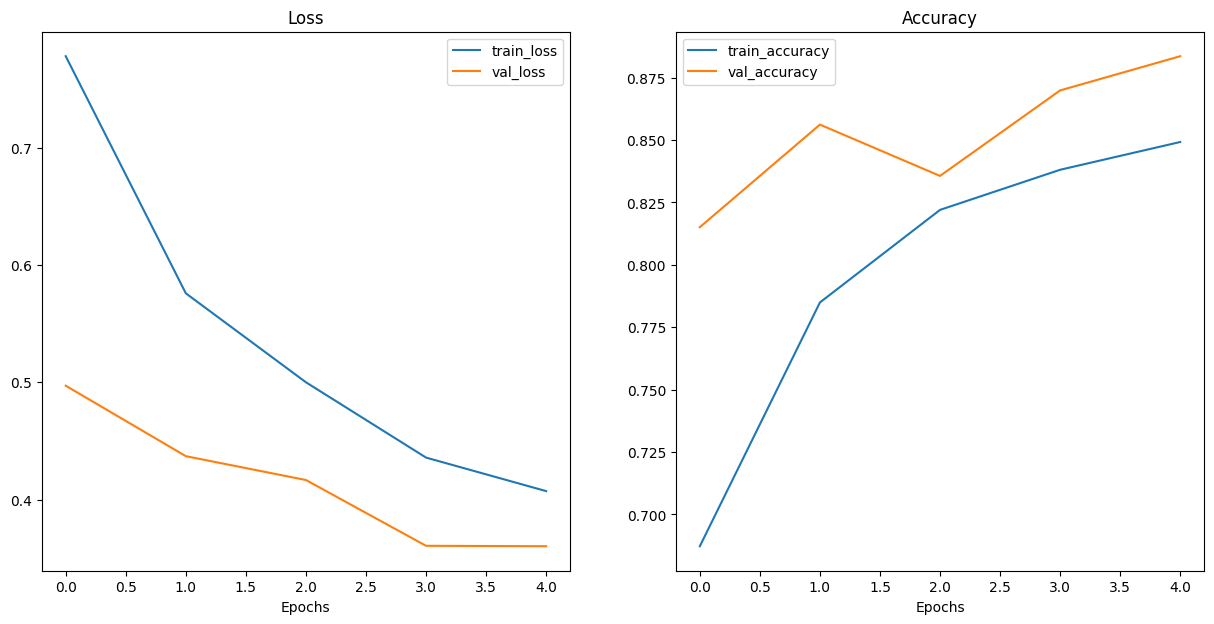

In [11]:
plot_curves(model_results)

To achieve better results, consider increasing the number of iterations during model training.

# 4. Saving and loading the model

During training, we preserved the model exhibiting the finest results on the validation dataset using:

`torch.save(model.state_dict(), os.path.join(path))`

Now, let's see how to initializes a ClassificationModel with an output shape of 4  and then load the trained weights. 

In [12]:
# Create a model  with the architecture specified by ClassificationModel class
model = ClassificationModel(output_shape = 4)
model.to(DEVICE)

# Update the model's parameters with the trained weights stored in MODEL_PATH
MODEL_PATH = '../data/models/baseline_model_WeatherDataset.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

We can use the model for inference or to compute metrics
> Currently, we have completed the model training, but its ability to generalize the learned knowledge remains unkown. To assess its performance, in notebook **"04_evaluation_methods"**, we will examine examples of inference on the test dataset and obtain metrics that determine how well the model performs on unseen data. 

# EXERCISE

Train a neural network capable of differentiating between cars, airplanes, and ships using the Transport_dataset. Follow the steps below:

- **1. Prepare the train_dataset**: Begin by defining the data transform and creating the train_dataset along with the train_dataloader. For this dataset, we won't define a "valid subset."

- **2. Build the model**: You can utilize the same architecture as defined in the ClassificationModel. Keep in mind that the output shape of the model must match the number of classes. 

- **3. Set up the train loop**: Since we only have a train_dataset, you can refer to the code provided on slide 17 of the pdf "Model_building_and_training_loop." Remember to define a loss function and an optimizer. (You don't need to plot the evolution of the loss and accuracy during training) 

- **4. Save your model**: Once the model is trained, save its trained weights in a .pth file."